In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import glob

In [2]:
# game_results_big10_2023 = pd.read_csv('../data/game_results_big10_2023.csv')
#betting_lines_big10_2023 = pd.read_csv('../data/betting_lines_big10_2023.csv')
# team_recruiting_rankings_2023 = pd.read_csv('../data/team_recruiting_rankings_2023.csv')
# team_talent_composite_ranking_2023 = pd.read_csv('../data/team_talent_composite_ranking_2023.csv')
# team_stats_big10_2023 = pd.read_csv('../data/team_stats_big10_2023.csv')

In [3]:
team_stat_float_columns = ['defensiveTDs',
       'firstDowns', 'fumblesLost', 'fumblesRecovered',
       'interceptionTDs', 'interceptionYards', 'interceptions',
       'kickReturnTDs', 'kickReturnYards', 'kickReturns', 'kickingPoints',
       'netPassingYards', 'passesDeflected', 'passesIntercepted', 'passingTDs',
        'puntReturnTDs', 'puntReturnYards', 'puntReturns',
       'qbHurries', 'rushingAttempts', 'rushingTDs', 'rushingYards', 'sacks',
       'tackles', 'tacklesForLoss', 'totalFumbles',
       'totalYards', 'turnovers', 'yardsPerPass',
       'yardsPerRushAttempt']
team_stat_nonfloat_stat_columns = ['HomeAway','completionAttempts', 'fourthDownEff', 'possessionTime', 'thirdDownEff', 'totalPenaltiesYards']

In [4]:
game_results_big10_all_list = []
for year in glob.glob('../data/game_results_big10/*'): 
    game_results_big10_year = pd.read_csv(year)
    game_results_big10_year['Home_Minus_Away_Points'] = game_results_big10_year['Home Points'] - game_results_big10_year['Away Points']
    game_results_big10_year['Home_Team_Win'] = game_results_big10_year['Home_Minus_Away_Points'] > 0
    # try:
    #     pd.concat([game_results_big10_all, game_results_big10_year])
    # except:
    game_results_big10_all_list.append(game_results_big10_year)
game_results_big10_all = pd.concat(game_results_big10_all_list)

In [5]:
betting_lines_all_list = []
for year in glob.glob('../data/betting_lines/*'):
    betting_lines_year = pd.read_csv(year)
    betting_lines_all_list.append(betting_lines_year)
betting_lines_all = pd.concat(betting_lines_all_list)

betting_lines_all['HomeMoneyline_implied_proba'] = np.where(betting_lines_all['HomeMoneyline'] > 0, 100/(100+betting_lines_all['HomeMoneyline']), -betting_lines_all['HomeMoneyline']/(100-betting_lines_all['HomeMoneyline']))
betting_lines_all['AwayMoneyline_implied_proba'] = np.where(betting_lines_all['AwayMoneyline'] > 0, 100/(100+betting_lines_all['AwayMoneyline']), -betting_lines_all['AwayMoneyline']/(100-betting_lines_all['AwayMoneyline']))

betting_lines_all_draftkings = betting_lines_all[betting_lines_all['LineProvider'] == 'DraftKings']
#betting_lines_all_teamrankings_lineprovider = betting_lines_all[betting_lines_all['LineProvider'] == 'teamrankings']
betting_lines_all_draftkings.head()
#betting_lines_all_teamrankings_lineprovider.head()

,Id,HomeTeam,HomeScore,AwayTeam,AwayScore,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline,HomeMoneyline_implied_proba,AwayMoneyline_implied_proba
2,401525857,Oklahoma State,29,Kansas State,21,DraftKings,53.5,11.5,Kansas State -11.5,11.0,55.0,360.0,-440.0,0.217391,0.814815
4,401520340,Michigan State,0,Michigan,49,DraftKings,46.0,24.5,Michigan -24.5,19.0,NaN,1700.0,-4500.0,0.055556,0.978261
7,401520343,Ohio State,20,Penn State,12,DraftKings,45.5,-4.0,Ohio State -4,-10.0,NaN,-192.0,160.0,0.657534,0.384615
10,401525530,Florida State,38,Duke,20,DraftKings,49.5,-14.5,Florida State -14.5,-15.5,49.0,-600.0,440.0,0.857143,0.185185
13,401520333,Alabama,34,Tennessee,20,DraftKings,47.5,-9.5,Alabama -9.5,-9.5,NaN,-375.0,295.0,0.789474,0.253165


In [6]:
game_results_big10_all.iloc[:,20:]

,Home Line Scores[3],Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Id,Away Team,Away Conference,Away Division,Away Points,Away Line Scores[0],...,Away Post Win Prob,Away Pregame Elo,Away Postgame Elo,Excitement Index,Highlights,Notes,Home_Minus_Away_Points,Home_Team_Win,Home Line Scores[4],Away Line Scores[4]
0,0.0,NaN,NaN,NaN,282,Indiana State,MVFC,fcs,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,49.0,True,NaN,NaN
1,14.0,NaN,NaN,NaN,2249,Glenville State,NaN,NaN,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,True,NaN,NaN
2,15.0,NaN,NaN,NaN,2695,West Alabama,NaN,NaN,20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,True,NaN,NaN
3,3.0,NaN,1748.0,1740.0,30,USC,Pac-10,fbs,24.0,7.0,...,NaN,1925.0,1933.0,NaN,NaN,BCA CLASSIC AT LANDOVER MD,-11.0,False,NaN,NaN
4,0.0,NaN,NaN,NaN,2083,Bucknell,Patriot,fcs,14.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,6.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,6.0,0.811580,2160.0,2165.0,194,Ohio State,Big Ten,fbs,24.0,3.0,...,0.188420,2113.0,2108.0,5.946460,NaN,NaN,6.0,True,NaN,NaN
102,7.0,0.050421,1447.0,1421.0,120,Maryland,Big Ten,fbs,42.0,21.0,...,0.949579,1623.0,1649.0,2.722768,NaN,NaN,-18.0,False,NaN,NaN
103,20.0,0.814671,1510.0,1504.0,77,Northwestern,Big Ten,fbs,45.0,7.0,...,0.185329,1457.0,1463.0,6.796055,NaN,NaN,-2.0,False,NaN,NaN
104,0.0,0.016186,1502.0,1479.0,275,Wisconsin,Big Ten,fbs,28.0,0.0,...,0.983814,1598.0,1621.0,4.302649,NaN,NaN,-14.0,False,NaN,NaN


In [7]:
home_team_stats_big10_all_list = []
away_team_stats_big10_all_list = []
home_minus_away_team_stats_big10_all_list = []
for year in glob.glob('../data/team_stats_big10/*'):
    team_stats_big10_year = pd.read_csv(year)
    
    team_stats_big10_year_pivoted = team_stats_big10_year.pivot(index= ['Game Id', 'School', 'HomeAway'], columns='Stat Category', values='Stat').reset_index()
    display(team_stats_big10_year_pivoted)
    for col in team_stat_float_columns:
        try:
            team_stats_big10_year_pivoted[col] = team_stats_big10_year_pivoted[col].astype('float64')
        except:
            team_stats_big10_year_pivoted[col] = np.nan
    
    home_team_stats_big10_year = team_stats_big10_year_pivoted[team_stats_big10_year_pivoted['HomeAway']=='home'].reset_index().drop(columns='index').copy()
    away_team_stats_big10_year = team_stats_big10_year_pivoted[team_stats_big10_year_pivoted['HomeAway']=='away'].reset_index().drop(columns='index').copy()
    
    team_stats_big10_year_home_minus_away =  home_team_stats_big10_year.copy()
    for col in team_stat_float_columns:
        team_stats_big10_year_home_minus_away[col] = home_team_stats_big10_year[col].subtract(away_team_stats_big10_year[col], fill_value=0).copy()
    
    home_team_stats_big10_year = home_team_stats_big10_year.drop(columns=['HomeAway']).rename(columns = {'Game Id':'Id', 'School':'Team'}).copy()
    away_team_stats_big10_year = away_team_stats_big10_year.drop(columns=['HomeAway']).rename(columns = {'Game Id':'Id', 'School':'Team'}).copy()
    team_stats_big10_year_home_minus_away = team_stats_big10_year_home_minus_away.drop(columns=team_stat_nonfloat_stat_columns).add_prefix('Home_Minus_Away_').rename(columns = {'Home_Minus_Away_Game Id':'Id', 'Home_Minus_Away_School':'HomeTeam'}).copy()
    #NOTE: team_stat_nonfloat_stat_columns may need to be adjusted if any of those columns are desired to be subtracted later

    home_team_stats_big10_all_list.append(home_team_stats_big10_year)
    away_team_stats_big10_all_list.append(away_team_stats_big10_year)
    home_minus_away_team_stats_big10_all_list.append(team_stats_big10_year_home_minus_away)

home_team_stats_big10_all = pd.concat(home_team_stats_big10_all_list)
away_team_stats_big10_all = pd.concat(away_team_stats_big10_all_list)
home_minus_away_team_stats_big10_all = pd.concat(home_minus_away_team_stats_big10_all_list)

Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,242462628,Northwestern,away,39-62,32,2-3,0,1,0,0,...,3,38,2,124,7-18,0-0,637,1,8.3,3.3
1,242462628,TCU,home,20-38,22,0-0,1,0,0,29,...,2,36,2,157,6-14,0-0,525,2,9.7,4.4
2,242480084,Central Michigan,away,23-43,23,0-2,0,2,NaN,NaN,...,1,34,0,114,6-15,0-0,389,2,6.4,3.4
3,242480084,Indiana,home,11-17,19,0-1,2,0,1,98,...,4,51,3,203,10-14,0-0,334,2,7.7,4.0
4,242480130,Miami (OH),away,19-40,13,0-1,2,0,0,18,...,5,25,1,33,7-16,0-0,250,7,5.4,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,243252509,Purdue,home,35-56,37,0-1,2,1,NaN,NaN,...,5,34,2,173,10-15,0-0,763,2,10.5,5.1
152,243320062,Hawai'i,home,31-58,27,0-0,0,0,0,0,...,4,23,2,93,11-17,0-0,498,2,7.0,4.0
153,243320062,Northwestern,away,19-41,24,2-3,0,0,0,6,...,2,46,3,216,5-17,0-0,535,1,7.8,4.7
154,243390062,Hawai'i,home,29-49,23,0-2,0,0,NaN,NaN,...,2,23,2,120,7-14,0-0,536,0,8.5,5.2


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,252440202,Minnesota,away,14-25,24,0-1,1,3,NaN,NaN,...,2,44,4,301,6-12,0-0,536,2,9.4,6.8
1,252440202,Tulsa,home,27-41,19,1-1,3,1,0,0,...,1,35,0,135,8-19,0-0,353,4,5.3,3.9
2,252452117,Central Michigan,home,18-36,15,0-0,0,0,0,0,...,6,32,1,167,3-18,0-0,383,0,6.0,5.2
3,252452117,Indiana,away,17-35,20,1-1,0,0,NaN,NaN,...,7,45,0,109,3-17,0-0,385,1,7.9,2.4
4,252460077,Northwestern,home,28-40,29,0-1,2,2,0,3,...,5,47,3,194,11-21,0-0,550,3,8.9,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,253230356,Northwestern,away,25-31,36,2-3,0,0,0,16,...,1,61,3,356,9-15,0-0,596,0,7.7,5.8
150,253232294,Iowa,home,20-34,28,0-1,0,0,0,16,...,1,40,2,236,7-13,0-0,613,1,11.1,5.9
151,253232294,Minnesota,away,26-46,24,0-2,0,0,1,60,...,1,34,2,129,6-15,0-0,444,2,6.8,3.8
152,253290062,Hawai'i,home,33-54,23,2-3,1,0,NaN,NaN,...,1,17,0,43,4-14,0-0,446,2,7.5,2.5


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,262430193,Miami (OH),home,16-26,13,0-2,0,0,NaN,NaN,...,NaN,29,0,72,2-12,4-50,247,0,6.7,2.5
1,262430193,Northwestern,away,13-17,16,0-1,0,0,NaN,NaN,...,3,39,1,193,6-13,5-42,299,0,6.2,4.9
2,262432309,Kent State,home,7-13,13,0-0,3,0,0,32,...,NaN,37,0,132,6-10,4-28,282,6,11.5,3.6
3,262432309,Minnesota,away,8-15,25,1-1,0,3,0,0,...,2,55,5,322,7-10,5-42,468,1,9.7,5.9
4,262450084,Indiana,home,20-35,20,1-2,1,1,1,103,...,3,28,1,71,4-12,8-90,323,2,7.2,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,263220275,Wisconsin,home,16-27,19,0-1,2,4,0,5,...,4,42,3,128,3-11,2-25,436,3,11.4,3.0
174,263222509,Indiana,away,26-42,20,2-4,4,1,0,50,...,3,31,1,215,5-15,6-46,505,4,6.9,6.9
175,263222509,Purdue,home,18-32,22,0-0,1,4,NaN,NaN,...,3,39,3,175,6-13,1-9,435,5,8.1,4.5
176,263290062,Hawai'i,home,33-48,33,0-1,2,1,0,5,...,3,20,2,219,3-6,4-37,653,3,9.0,10.9


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,272440077,Northeastern,away,19-32,14,0-0,0,0,NaN,NaN,...,NaN,24,0,109,0-0,5-54,260,0,4.7,4.5
1,272440077,Northwestern,home,25-31,27,2-3,0,0,NaN,NaN,...,1,49,2,163,8-16,5-45,417,0,8.2,3.3
2,272440127,Michigan State,home,22-30,28,0-0,0,0,0,10,...,3,48,5,298,8-13,4-35,593,0,9.8,6.2
3,272440127,UAB,away,21-39,17,0-0,0,0,NaN,NaN,...,3,32,0,12,8-19,5-20,226,1,5.5,0.4
4,272440130,Appalachian State,away,17-23,19,0-0,1,1,0,26,...,NaN,44,1,160,0-0,7-45,387,3,9.9,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,273210135,Wisconsin,away,7-15,19,1-1,0,1,0,26,...,3,48,4,325,4-12,5-29,443,1,7.9,6.8
170,273210356,Illinois,home,15-23,32,0-0,1,0,0,1,...,1,65,2,321,8-14,4-35,541,2,9.6,4.9
171,273210356,Northwestern,away,29-49,21,0-2,0,1,0,6,...,2,18,1,69,2-10,9-79,379,2,6.3,3.8
172,273212294,Iowa,home,20-38,19,0-1,1,0,NaN,NaN,...,4,32,0,148,6-15,3-20,397,3,6.6,4.6


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,282430025,California,home,20-30,22,0-0,0,0,0,0,...,4,36,2,203,4-10,8-67,467,2,8.8,5.6
1,282430025,Michigan State,away,20-48,23,0-1,0,0,1,84,...,3,31,2,81,6-16,8-82,402,1,6.7,2.6
2,282430077,Northwestern,home,23-35,25,0-0,1,0,1,26,...,3,42,0,269,5-11,6-65,484,2,6.1,6.4
3,282430077,Syracuse,away,14-28,11,0-0,0,1,NaN,NaN,...,4,30,1,122,3-14,5-36,225,1,3.7,4.1
4,282430084,Indiana,home,18-30,21,0-2,0,1,NaN,NaN,...,3,41,2,297,4-12,7-63,450,1,5.1,7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,283270213,Penn State,home,19-31,19,0-1,0,0,0,14,...,6,35,2,138,13-17,5-38,557,0,13.5,3.9
172,283270275,Cal Poly,away,8-16,23,2-2,0,1,0,17,...,1,59,3,276,9-17,1-5,371,0,5.9,4.7
173,283270275,Wisconsin,home,13-22,17,0-1,1,0,NaN,NaN,...,NaN,32,4,184,5-11,2-10,429,2,11.1,5.8
174,283272509,Indiana,away,13-25,13,0-2,1,0,NaN,NaN,...,NaN,32,0,122,5-14,7-54,214,3,3.7,3.8


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,292460084,Eastern Kentucky,away,17-26,17,0-0,1,1,0,13,...,2,31,0,100,3-11,9-65,378,1,10.7,3.2
1,292460084,Indiana,home,27-36,22,1-1,1,1,NaN,NaN,...,3,31,1,73,6-13,8-43,399,3,9.1,2.4
2,292480077,Northwestern,home,16-22,22,2-3,0,0,0,0,...,5,54,5,221,12-17,6-45,485,1,12.0,4.1
3,292480077,Towson,away,15-27,12,1-2,0,0,0,1,...,NaN,30,1,65,5-13,3-25,205,2,5.2,2.2
4,292480127,Michigan State,home,19-35,29,0-0,0,0,NaN,NaN,...,6,40,0,175,7-13,5-46,493,0,9.1,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,293312132,Illinois,away,22-35,24,3-3,0,1,NaN,NaN,...,3,45,1,169,5-17,8-69,476,0,8.8,3.8
172,293390062,Hawai'i,home,15-34,14,0-0,0,0,NaN,NaN,...,1,17,0,17,3-11,5-43,214,2,5.8,1.0
173,293390062,Wisconsin,away,16-20,26,1-1,0,0,0,8,...,3,52,7,301,8-13,8-71,554,0,12.6,5.8
174,293390356,Fresno State,away,13-21,21,2-2,0,1,1,26,...,3,44,4,233,6-14,2-31,416,1,8.7,5.3


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,302450084,Indiana,home,18-30,18,0-0,0,0,1,62,...,2,26,3,155,2-10,3-25,360,0,6.8,6.0
1,302450084,Towson,away,16-35,16,2-5,0,0,NaN,NaN,...,3,42,0,227,4-16,4-40,392,3,4.7,5.4
2,302450194,Marshall,away,18-35,11,0-0,2,0,NaN,NaN,...,3,21,0,44,4-14,8-60,199,3,4.4,2.1
3,302450194,Ohio State,home,18-27,23,1-1,0,2,1,30,...,5,41,2,280,4-12,7-47,529,0,9.2,6.8
4,302452393,Middle Tennessee,home,13-18,12,0-0,1,0,NaN,NaN,...,NaN,22,1,146,1-8,4-27,318,2,9.6,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,303310275,Wisconsin,home,15-19,29,0-0,0,3,1,97,...,4,54,5,329,5-11,2-25,559,0,12.1,6.1
172,303312509,Indiana,away,31-52,26,0-0,2,0,0,0,...,1,30,1,73,5-13,5-30,403,2,6.3,2.4
173,303312509,Purdue,home,16-30,13,0-0,0,2,NaN,NaN,...,3,30,1,58,2-13,11-106,310,1,8.4,1.9
174,303370278,Fresno State,home,18-26,18,1-1,1,0,NaN,NaN,...,5,30,0,60,3-11,6-55,364,1,11.7,2.0


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,312440275,UNLV,away,18-27,19,2-2,0,0,NaN,NaN,...,2,38,0,146,2-12,7-65,292,0,5.4,3.8
1,312440275,Wisconsin,home,11-15,20,1-1,0,0,NaN,NaN,...,3,38,5,241,2-5,6-50,499,0,17.2,6.3
2,312450127,Michigan State,home,19-23,22,0-0,1,0,0,13,...,4,35,3,159,3-7,7-50,396,1,10.3,4.5
3,312450127,Youngstown State,away,17-35,20,0-1,0,1,NaN,NaN,...,1,32,0,136,8-15,4-32,262,1,3.6,4.3
4,312460030,Minnesota,away,14-26,20,1-1,0,1,NaN,NaN,...,2,34,1,110,6-14,8-44,302,1,7.4,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,313300135,Minnesota,home,7-15,19,0-0,0,1,NaN,NaN,...,4,53,2,248,8-16,2-30,333,0,5.7,4.7
188,313300275,Penn State,away,11-25,12,0-2,3,1,NaN,NaN,...,4,27,0,114,4-13,7-78,233,4,4.8,4.2
189,313300275,Wisconsin,home,19-29,27,0-0,1,3,0,0,...,3,49,4,264,9-16,4-35,450,1,6.4,5.4
190,313370127,Michigan State,home,22-30,23,1-1,1,0,NaN,NaN,...,5,34,2,190,7-13,7-50,471,2,9.4,5.6


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,322432439,Minnesota,away,17-30,22,0-0,1,0,0,-2,...,3,46,1,209,3-15,11-86,478,2,9.0,4.5
1,322432439,UNLV,home,16-35,18,1-1,0,1,0,44,...,1,37,2,159,6-17,7-54,275,3,3.3,4.3
2,322440127,Boise State,away,15-32,13,0-1,1,1,1,69,...,1,24,0,37,5-14,3-35,206,2,5.3,1.5
3,322440127,Michigan State,home,22-38,26,1-2,1,1,0,0,...,1,52,2,213,10-19,10-90,461,4,6.5,4.1
4,322450084,Indiana,home,26-36,25,2-3,0,1,0,4,...,NaN,47,2,171,10-20,8-65,451,0,7.8,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,323290213,Wisconsin,away,12-25,16,1-2,0,0,NaN,NaN,...,1,43,1,158,5-16,4-45,349,1,7.6,3.7
190,323292509,Indiana,away,31-53,22,1-3,1,0,0,70,...,1,35,4,164,10-19,9-44,512,4,6.6,4.7
191,323292509,Purdue,home,21-32,23,2-2,0,1,0,83,...,NaN,38,3,185,2-12,4-40,558,1,11.7,4.9
192,323360275,Nebraska,away,18-34,23,1-2,1,0,NaN,NaN,...,1,44,4,282,6-16,4-40,477,3,5.7,6.4


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,332410084,Indiana,home,17-30,29,1-2,1,1,0,28,...,4,54,3,313,9-18,6-66,632,3,10.6,5.8
1,332410084,Indiana State,away,12-32,15,1-3,1,1,1,30,...,2,39,0,131,3-16,7-83,306,2,5.5,3.4
2,332410135,Minnesota,home,10-23,17,1-1,0,0,1,89,...,1,38,3,221,8-14,1-5,320,1,4.3,5.8
3,332410135,UNLV,away,36-51,21,4-4,0,0,0,0,...,1,34,1,193,6-18,1-15,419,2,4.4,5.7
4,332420127,Michigan State,home,17-37,18,0-0,1,1,1,6,...,5,42,1,181,5-19,6-75,297,1,3.1,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,333340275,Wisconsin,home,29-55,27,2-3,0,0,NaN,NaN,...,1,30,0,120,8-17,4-35,459,3,6.2,4.0
190,333340356,Illinois,home,31-45,29,0-0,0,0,NaN,NaN,...,1,32,2,185,7-15,4-21,492,1,6.8,5.8
191,333340356,Northwestern,away,31-45,31,0-1,0,0,0,4,...,3,51,0,146,12-20,2-5,560,0,9.2,2.9
192,333410127,Michigan State,home,24-40,23,2-2,0,0,NaN,NaN,...,1,32,1,134,5-15,3-20,438,1,7.6,4.2


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400547642,Penn State,away,32-47,24,1-2,1,1,NaN,NaN,...,2,28,1,57,10-18,9-90,511,3,9.7,2.0
1,400547642,UCF,home,12-22,11,1-2,1,1,0,0,...,NaN,29,2,24,5-13,8-47,246,1,10.1,0.8
2,400547654,Maryland,away,17-28,17,0-0,4,0,0,0,...,5,40,0,116,8-14,4-35,317,6,7.2,2.9
3,400547654,South Florida,home,15-37,16,0-2,0,4,0,0,...,1,37,1,83,9-21,6-39,257,1,4.7,2.2
4,400547674,Cincinnati,away,21-33,15,0-0,0,1,NaN,NaN,...,NaN,19,0,70,4-11,6-40,422,0,10.7,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,400548001,Wisconsin,home,24-29,25,2-3,0,1,0,27,...,2,39,1,167,6-12,4-38,456,1,10.0,4.3
222,400548002,Bowling Green,away,15-33,11,0-0,1,2,0,22,...,NaN,29,2,93,2-16,7-36,271,2,5.4,3.2
223,400548002,Wisconsin,home,9-18,29,0-0,2,1,0,43,...,7,60,8,644,3-7,5-55,756,3,6.2,10.7
224,400609096,Ohio State,home,12-18,24,0-0,0,1,0,67,...,2,38,4,301,2-8,5-44,558,0,14.3,7.9


Stat Category,Game Id,School,HomeAway,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,puntReturns,rushingAttempts,rushingTDs,rushingYards,thirdDownEff,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400603827,Alabama,home,22-29,27,1-1,0,0,0,41,...,4,37,4,238,4-11,11-120,502,0,9.1,6.4
1,400603827,Wisconsin,away,26-39,17,0-0,0,0,NaN,NaN,...,2,21,0,40,6-14,5-50,268,1,5.8,1.9
2,400756883,Michigan,away,27-43,20,1-2,0,0,0,17,...,NaN,29,0,76,6-16,3-25,355,3,6.5,2.6
3,400756883,Utah,home,24-33,20,2-3,0,0,1,65,...,1,37,2,127,3-13,6-55,337,1,6.4,3.4
4,400756891,Northwestern,home,12-25,17,1-1,0,1,0,17,...,1,54,1,225,12-22,5-57,330,0,4.2,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,400763582,Rutgers,home,21-33,23,0-1,0,0,0,0,...,1,47,1,186,3-11,9-92,530,1,10.4,4.0
222,400835430,Illinois,home,14-29,19,2-2,0,1,0,43,...,4,36,2,134,3-13,8-80,342,1,7.2,3.7
223,400835430,Kent State,away,19-40,15,2-5,1,0,0,0,...,5,39,0,59,3-18,11-82,245,4,4.7,1.5
224,400852682,Iowa,home,18-27,13,0-0,2,0,0,4,...,1,24,0,52,3-12,5-45,268,3,8.0,2.2


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400868888,Iowa,home,20-30,0,25,1-1,0,0,0,...,3,35,5,4-10,NaN,5-35,435,0,7.9,5.5
1,400868888,Iowa State,away,14-35,0,16,1-2,0,0,NaN,...,2,41,6,3-15,NaN,10-73,291,1,4.7,3.6
2,400868927,BYU,away,18-29,0,24,2-4,0,0,0,...,3,21,5,10-16,NaN,3-24,398,0,4.8,5.3
3,400868927,Michigan State,home,13-21,0,13,2-3,0,0,NaN,...,0,33,2,6-14,1,4-39,206,1,5.8,2.7
4,400868948,Michigan State,away,19-26,0,22,1-1,0,2,0,...,2,36,6,9-18,0,3-45,501,1,9.3,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,400869702,Penn State,home,18-24,0,18,0-0,0,1,NaN,...,4,31,10,4-10,0,1-15,463,0,16.1,2.3
208,400869703,Minnesota,away,9-26,0,18,0-0,0,1,NaN,...,1,42,10,3-14,0,3-26,286,4,6.1,3.4
209,400869703,Wisconsin,home,13-22,0,19,0-0,1,0,0,...,5,35,7,4-12,1,3-35,362,1,6.9,4.5
210,400926946,Penn State,home,22-31,0,21,0-3,2,0,NaN,...,2,49,8,3-10,2,3-25,435,2,12.4,1.8


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400933830,Florida,home,14-26,2,9,1-2,3,0,2,...,5,54,11,2-13,5,5-45,192,3,7.0,0.4
1,400933830,Michigan,away,12-26,0,19,1-1,0,3,NaN,...,6,32,11,6-18,0,7-55,433,2,8.4,4.4
2,400933860,Missouri,home,12-28,0,10,0-0,1,0,0,...,3,55,8,2-11,1,6-46,203,3,4.8,2.9
3,400933860,Purdue,away,26-34,0,26,2-3,0,1,0,...,0,29,5,8-17,1,3-25,477,1,8.0,4.1
4,400934495,Maryland,away,12-15,0,18,0-0,0,1,0,...,6,62,9,3-11,0,10-53,482,1,14.6,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,400941799,South Florida,home,17-32,0,38,0-0,0,0,0,...,2,30,4,12-18,NaN,16-155,680,1,9.5,5.7
208,400955156,Ohio State,away,12-26,0,16,2-2,1,0,0,...,3,42,5,6-16,2,5-48,449,3,8.1,5.7
209,400955156,Wisconsin,home,20-41,1,16,0-1,0,1,1,...,0,37,2,5-16,1,6-55,298,2,5.8,1.9
210,400982707,Charleston Southern,away,0-10,0,6,0-1,0,2,0,...,1,48,6,1-14,0,11-85,134,0,0.0,3.0


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401012279,Missouri,away,26-43,0,31,3-3,0,0,0,...,1,46,6,5-16,1,4-27,608,1,8.7,5.1
1,401012279,Purdue,home,39-55,0,23,0-1,0,0,0,...,1,47,4,7-14,1,7-65,614,1,10.4,2.6
2,401012682,Ohio State,home,25-34,0,34,1-1,1,2,NaN,...,5,38,6,12-14,1,6-50,721,2,10.2,7.1
3,401012682,Oregon State,away,14-24,0,15,1-1,2,1,0,...,0,49,1,6-17,5,5-49,392,2,8.2,5.0
4,401012727,Arizona State,home,30-48,0,27,1-2,0,0,0,...,2,44,5,6-16,1,4-40,424,1,7.9,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,401013356,Wisconsin,home,18-28,0,20,2-3,0,0,NaN,...,1,24,6,4-13,NaN,6-33,394,1,6.8,4.7
208,401056702,Northwestern,away,26-43,0,21,0-1,1,1,0,...,4,64,10,5-15,1,3-15,418,3,6.2,6.1
209,401056702,Ohio State,home,34-41,0,31,1-1,1,1,0,...,5,42,8,10-18,1,9-90,607,2,12.2,2.3
210,401085385,Bethune-Cookman,away,13-30,0,16,0-0,1,0,0,...,4,35,4,7-16,1,6-34,355,3,7.1,3.5


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401110785,Purdue,home,34-52,0,27,0-0,0,0,0,...,6,90,5,5-12,NaN,8-63,540,1,9.8,1.7
1,401110785,Vanderbilt,away,31-48,0,23,0-1,0,0,0,...,0,78,6,6-15,2,13-100,491,1,8.8,2.6
2,401112086,Iowa,away,22-35,0,18,0-0,0,4,NaN,...,1,32,4,10-19,0,4-15,313,0,5.7,3.0
3,401112086,Iowa State,home,25-35,0,20,0-1,2,0,NaN,...,4,34,6,3-9,4,4-21,418,2,9.3,4.8
4,401112130,Purdue,home,13-29,0,8,0-1,0,0,0,...,6,45,10,4-15,2,2-20,204,2,6.2,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,401112269,Wisconsin,home,17-20,0,29,1-1,1,2,NaN,...,18,72,10,11-15,6,3-31,520,1,8.6,6.3
208,401117856,South Florida,home,16-33,0,9,0-2,1,2,NaN,...,3,94,22,3-14,8,9-45,157,3,4.0,1.1
209,401117856,Wisconsin,away,19-26,1,22,1-1,1,2,0,...,4,70,5,6-13,2,4-40,435,1,7.7,5.4
210,401132983,Ohio State,away,20-32,0,28,2-3,1,0,NaN,...,2,42,8,6-14,NaN,4-40,492,1,10.0,3.7


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401247293,Nebraska,away,15-19,0,16,0-0,2,1,NaN,...,3,45,6,4-10,NaN,8-90,353,2,7.5,5.8
1,401247293,Ohio State,home,20-21,1,28,2-2,1,2,NaN,...,3,41,5,8-13,NaN,3-15,491,1,13.1,4.5
2,401247294,Michigan,away,15-25,1,18,0-1,0,1,0,...,5,45,8,4-8,NaN,7-80,478,0,9.0,8.2
3,401247294,Minnesota,home,18-31,0,21,1-3,1,0,NaN,...,1,37,2,6-14,NaN,5-39,326,2,6.4,3.1
4,401247295,Indiana,home,19-36,0,16,0-1,1,1,0,...,1,57,6,4-12,NaN,4-36,211,2,4.7,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,401269381,Penn State,home,19-27,1,28,3-3,1,1,0,...,3,28,7,4-12,NaN,2-19,580,1,12.1,4.8
96,401269382,Nebraska,away,24-28,0,27,2-2,2,0,0,...,2,30,8,7-13,5,9-56,620,4,9.1,6.3
97,401269382,Rutgers,home,11-22,1,9,2-3,0,3,0,...,3,50,10,2-13,1,5-32,252,1,5.5,4.3
98,401269384,Minnesota,away,14-26,0,18,1-1,0,0,NaN,...,1,47,5,4-11,NaN,7-65,326,1,6.9,4.1


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401282070,Auburn,away,21-39,0,24,0-1,1,0,0,...,0,46,11,10-17,2,6-45,367,1,4.7,4.6
1,401282070,Penn State,home,29-33,0,22,0-2,0,1,NaN,...,0,44,3,5-10,1,5-30,386,1,9.2,2.5
2,401282179,Illinois,home,22-43,0,24,1-2,1,1,NaN,...,1,44,6,8-18,3,7-61,416,1,6.2,4.3
3,401282179,UT San Antonio,away,20-32,0,26,0-0,1,1,NaN,...,0,37,6,9-17,1,3-43,497,1,8.8,4.3
4,401282214,Indiana,away,35-53,0,35,1-1,0,0,NaN,...,1,31,3,11-18,1,4-20,507,0,7.0,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,401286207,Maryland,home,27-32,0,32,2-2,0,0,0,...,2,30,5,9-15,1,5-50,574,0,10.8,4.6
208,401327913,Fordham,away,18-30,0,12,1-4,0,2,NaN,...,1,52,3,2-13,0,2-15,292,3,5.4,4.6
209,401327913,Nebraska,home,21-30,0,34,4-4,2,0,0,...,1,26,5,12-19,4,2-10,633,2,10.1,5.1
210,401331447,Iowa,home,19-38,0,15,0-1,0,0,0,...,1,37,3,5-19,1,5-55,279,1,4.6,3.2


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401403882,Auburn,home,21-38,0,23,1-2,2,0,NaN,...,0,40,3,5-15,3,7-61,415,4,7.8,3.3
1,401403882,Penn State,away,17-23,0,18,0-1,0,4,0,...,6,52,11,5-11,2,9-80,477,0,10.1,6.3
2,401403984,Washington State,away,17-28,0,10,1-2,1,2,0,...,1,47,7,2-11,1,5-50,253,3,7.1,2.4
3,401403984,Wisconsin,home,18-31,0,22,0-1,2,1,0,...,2,27,4,8-15,2,11-106,401,3,7.3,4.0
4,401403988,Colorado,away,10-24,0,14,4-5,1,0,0,...,2,49,6,1-12,2,4-35,226,1,3.8,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,401426563,Western Kentucky,away,33-45,0,25,0-1,1,1,NaN,...,3,50,7,5-14,2,8-83,545,2,7.3,6.0
208,401426566,Florida Atlantic,away,18-30,0,21,1-2,1,2,0,...,1,53,4,5-16,2,6-77,419,2,7.7,4.4
209,401426566,Purdue,home,22-31,0,21,1-2,1,2,0,...,0,47,2,3-12,2,5-55,354,2,5.4,5.2
210,401437031,Michigan,home,11-17,0,17,2-2,0,0,0,...,4,3,4,6-12,NaN,3-25,386,1,9.5,5.9


Stat Category,Game Id,School,HomeAway,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,401520148,Minnesota,home,24-44,0,20,2-2,0,1,0,...,3,38,5,8-17,0,3-25,251,1,4.5,2.2
1,401520148,Nebraska,away,11-19,0,18,0-0,1,0,0,...,3,36,5,5-11,1,7-55,295,4,6.0,4.9
2,401520155,Illinois,home,18-26,1,21,2-3,0,0,1,...,1,50,5,2-8,NaN,10-100,374,1,7.9,4.8
3,401520155,Toledo,away,20-37,0,27,2-2,0,0,0,...,2,44,4,7-15,2,7-40,416,1,6.2,4.4
4,401520156,Indiana,home,9-20,0,8,0-2,0,0,0,...,0,41,5,4-15,NaN,8-75,153,0,4.1,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,401520439,Rutgers,home,13-34,0,20,1-3,0,1,0,...,1,30,7,8-19,1,8-80,355,1,4.9,4.2
208,401521330,Notre Dame,home,17-25,0,22,0-2,0,0,NaN,...,1,32,2,5-10,NaN,4-50,351,0,7.0,4.5
209,401521330,Ohio State,away,21-38,0,19,1-3,0,0,NaN,...,0,36,2,10-17,NaN,5-35,366,0,6.3,4.7
210,401539480,Iowa,home,18-32,0,7,0-3,3,0,NaN,...,4,36,4,4-15,3,7-46,155,3,3.8,1.5


In [8]:
team_stats_results_big10_all = pd.merge(game_results_big10_all, home_minus_away_team_stats_big10_all, on=['Id'], how='inner')
team_stats_results_big10_all = pd.merge(team_stats_results_big10_all, betting_lines_all_draftkings, on=['Id'], how='left')
team_stats_results_big10_all.tail()

,Id,Season,Week,Season Type,Start Date,Start Time Tbd,Completed,Neutral Site,Conference Game,Attendance,...,LineProvider,OverUnder,Spread,FormattedSpread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline,HomeMoneyline_implied_proba,AwayMoneyline_implied_proba
1898,401520434,2023,13,regular,2023-11-25T17:00:00.000Z,False,True,False,True,110615.0,...,DraftKings,47.0,-4.0,Michigan -4,-2.5,NaN,-155.0,130.0,0.607843,0.434783
1899,401520439,2023,13,regular,2023-11-25T20:30:00.000Z,False,True,False,True,NaN,...,DraftKings,NaN,2.0,Maryland -2,2.0,NaN,110.0,-130.0,0.476190,0.565217
1900,401520431,2023,13,regular,2023-11-25T20:30:00.000Z,False,True,False,True,42310.0,...,DraftKings,NaN,-5.0,Illinois -5,-5.0,NaN,-192.0,160.0,0.657534,0.384615
1901,401520436,2023,13,regular,2023-11-25T20:30:00.000Z,False,True,False,True,48119.0,...,DraftKings,42.0,1.5,Wisconsin -1.5,1.5,42.0,130.0,-155.0,0.434783,0.607843
1902,401539480,2023,14,regular,2023-12-03T01:00:00.000Z,False,True,True,True,67842.0,...,DraftKings,35.0,23.5,Michigan -23.5,23.5,35.0,1200.0,-2400.0,0.076923,0.960000


In [9]:
home_team_stats_big10_all = pd.merge(game_results_big10_all[['Id','Season']], home_team_stats_big10_all, on=['Id'], how='inner')
home_team_stats_big10_all

,Id,Season,Team,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,defensiveTDs,kickReturnTDs,kickReturnYards,kickReturns,passesDeflected,qbHurries,sacks,tackles,tacklesForLoss,totalFumbles
0,242462628,2004,TCU,20-38,22.0,0-0,1.0,0.0,0.0,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,242480130,2004,Michigan,16-28,14.0,0-1,0.0,2.0,1.0,203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,242482294,2004,Iowa,18-30,22.0,0-1,0.0,2.0,1.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,242480275,2004,Wisconsin,9-20,23.0,2-3,1.0,2.0,0.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,242480194,2004,Ohio State,16-29,21.0,0-1,2.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,401520434,2023,Michigan,17-21,18.0,3-3,0.0,0.0,0.0,18.0,...,0.0,0.0,16.0,1.0,4.0,1.0,1.0,35.0,1.0,NaN
1899,401520439,2023,Rutgers,13-34,20.0,1-3,0.0,1.0,0.0,3.0,...,0.0,0.0,26.0,1.0,1.0,2.0,1.0,30.0,7.0,1.0
1900,401520431,2023,Illinois,25-35,20.0,2-3,2.0,0.0,1.0,55.0,...,1.0,0.0,121.0,8.0,2.0,3.0,2.0,37.0,4.0,3.0
1901,401520436,2023,Minnesota,16-28,17.0,1-2,1.0,0.0,0.0,52.0,...,0.0,0.0,90.0,5.0,2.0,0.0,0.0,44.0,2.0,1.0


In [10]:
away_team_stats_big10_all = pd.merge(game_results_big10_all[['Id','Season']], away_team_stats_big10_all, on=['Id'], how='inner')
away_team_stats_big10_all

,Id,Season,Team,completionAttempts,firstDowns,fourthDownEff,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,...,defensiveTDs,kickReturnTDs,kickReturnYards,kickReturns,passesDeflected,qbHurries,sacks,tackles,tacklesForLoss,totalFumbles
0,242462628,2004,Northwestern,39-62,32.0,2-3,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,242480130,2004,Miami (OH),19-40,13.0,0-1,2.0,0.0,0.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,242482294,2004,Kent State,19-36,11.0,0-3,2.0,0.0,1.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,242480275,2004,UCF,13-24,11.0,0-0,2.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,242480194,2004,Cincinnati,17-37,11.0,1-3,0.0,2.0,0.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,401520434,2023,Ohio State,18-30,21.0,0-0,0.0,0.0,NaN,NaN,...,0.0,0.0,42.0,2.0,0.0,2.0,1.0,33.0,2.0,1.0
1899,401520439,2023,Maryland,24-31,24.0,1-1,1.0,0.0,0.0,0.0,...,0.0,0.0,13.0,1.0,7.0,3.0,2.0,33.0,4.5,1.0
1900,401520431,2023,Northwestern,24-32,20.0,0-0,0.0,2.0,0.0,13.0,...,0.0,0.0,98.0,5.0,4.0,0.0,2.0,33.0,5.0,1.0
1901,401520436,2023,Wisconsin,14-22,21.0,0-0,0.0,1.0,0.0,0.0,...,0.0,0.0,21.0,1.0,2.0,2.0,2.0,38.0,3.0,0.0


In [11]:
team_stats_results_big10_all_nonobjects = team_stats_results_big10_all.select_dtypes(exclude='object')
team_stats_results_big10_all_nonobjects.columns

Index(['Id', 'Season', 'Week', 'Completed', 'Neutral Site', 'Attendance',
       'Venue Id', 'Home Id', 'Home Points', 'Home Line Scores[0]',
       'Home Line Scores[1]', 'Home Line Scores[2]', 'Home Line Scores[3]',
       'Home Post Win Prob', 'Home Pregame Elo', 'Home Postgame Elo',
       'Away Id', 'Away Points', 'Away Line Scores[0]', 'Away Line Scores[1]',
       'Away Line Scores[2]', 'Away Line Scores[3]', 'Away Post Win Prob',
       'Away Pregame Elo', 'Away Postgame Elo', 'Excitement Index',
       'Home_Minus_Away_Points', 'Home_Team_Win', 'Home Line Scores[4]',
       'Away Line Scores[4]', 'Home_Minus_Away_firstDowns',
       'Home_Minus_Away_fumblesLost', 'Home_Minus_Away_fumblesRecovered',
       'Home_Minus_Away_interceptionTDs', 'Home_Minus_Away_interceptionYards',
       'Home_Minus_Away_interceptions', 'Home_Minus_Away_kickingPoints',
       'Home_Minus_Away_netPassingYards', 'Home_Minus_Away_passesIntercepted',
       'Home_Minus_Away_passingTDs', 'Home_Minus_Awa

In [12]:
team_stats_results_big10_all.select_dtypes(exclude='object').corr().iloc[25:,25:]

,Excitement Index,Home_Minus_Away_Points,Home_Team_Win,Home Line Scores[4],Away Line Scores[4],Home_Minus_Away_firstDowns,Home_Minus_Away_fumblesLost,Home_Minus_Away_fumblesRecovered,Home_Minus_Away_interceptionTDs,Home_Minus_Away_interceptionYards,...,HomeScore,AwayScore,OverUnder,Spread,OpeningSpread,OpeningOverUnder,HomeMoneyline,AwayMoneyline,HomeMoneyline_implied_proba,AwayMoneyline_implied_proba
Excitement Index,1.000000,-0.300818,-0.221047,NaN,NaN,-0.271759,0.048352,-0.052250,-0.033417,-0.044736,...,3.660927e-02,-0.091689,-0.325683,0.019624,0.025077,-0.371350,0.109635,0.256723,0.262844,-0.233402
Home_Minus_Away_Points,-0.300818,1.000000,0.768782,8.377078e-01,-0.279553,0.691777,-0.185295,0.185294,0.272420,0.388104,...,8.349406e-01,-0.807513,0.192482,-0.814413,-0.796173,0.204590,-0.456504,0.629830,0.763646,-0.749928
Home_Team_Win,-0.221047,0.768782,1.000000,8.432740e-01,-0.100504,0.494951,-0.179261,0.185707,0.233797,0.337050,...,6.844555e-01,-0.596130,0.093637,-0.617247,-0.601602,0.035220,-0.323853,0.462385,0.616480,-0.602057
Home Line Scores[4],NaN,0.837708,0.843274,1.000000e+00,0.286039,-0.063671,NaN,NaN,NaN,-0.326406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Away Line Scores[4],NaN,-0.279553,-0.100504,2.860388e-01,1.000000,-0.971334,NaN,NaN,NaN,0.065834,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Home_Minus_Away_firstDowns,-0.271759,0.691777,0.494951,-6.367145e-02,-0.971334,1.000000,0.012225,-0.013844,0.047600,0.070799,...,5.987262e-01,-0.626374,0.166223,-0.679028,-0.663023,0.092667,-0.412795,0.555213,0.565000,-0.551351
Home_Minus_Away_fumblesLost,0.048352,-0.185295,-0.179261,NaN,NaN,0.012225,1.000000,-0.953530,-0.019286,-0.010206,...,-1.073110e-01,0.096115,-0.120622,0.025445,0.004614,-0.180232,0.050549,-0.022329,-0.025087,0.014429
Home_Minus_Away_fumblesRecovered,-0.052250,0.185294,0.185707,NaN,NaN,-0.013844,-0.953530,1.000000,0.032333,0.025325,...,1.555487e-01,-0.110409,0.142674,-0.046052,-0.027156,0.217219,-0.054562,0.017976,0.017794,-0.008219
Home_Minus_Away_interceptionTDs,-0.033417,0.272420,0.233797,NaN,NaN,0.047600,-0.019286,0.032333,1.000000,0.641891,...,3.243916e-01,-0.238987,0.125819,-0.323561,-0.313235,0.151947,-0.125777,0.230832,0.373474,-0.386403
Home_Minus_Away_interceptionYards,-0.044736,0.388104,0.337050,-3.264056e-01,0.065834,0.070799,-0.010206,0.025325,0.641891,1.000000,...,4.041275e-01,-0.383871,-0.027124,-0.377934,-0.384242,-0.085650,-0.141829,0.281918,0.439933,-0.428692


In [13]:
teams_list = list(pd.unique(team_stats_results_big10_all[['Home Team','Away Team']].values.ravel('K')))
teams_list

['TCU',
 'Michigan',
 'Iowa',
 'Wisconsin',
 'Ohio State',
 'Rutgers',
 'Penn State',
 'Illinois',
 'Indiana',
 'Minnesota',
 'Purdue',
 'Northwestern',
 'Michigan State',
 'Notre Dame',
 'Oregon',
 'Boston College',
 'NC State',
 'Arizona',
 'Kentucky',
 'Arizona State',
 'Colorado State',
 "Hawai'i",
 'Tulsa',
 'Central Michigan',
 'Iowa State',
 'California',
 'North Carolina',
 'Miami (OH)',
 'Kent State',
 'Bowling Green',
 'Syracuse',
 'Ball State',
 'Texas',
 'Pittsburgh',
 'Nevada',
 'Northern Illinois',
 'Toledo',
 'Western Michigan',
 'UNLV',
 'Florida Atlantic',
 'Washington',
 'Eastern Michigan',
 'Temple',
 'Missouri',
 'Duke',
 'USC',
 'Fresno State',
 'Akron',
 'Virginia',
 'Cincinnati',
 'Middle Tennessee',
 'Vanderbilt',
 'Alabama',
 'Western Kentucky',
 'Rice',
 'Nebraska',
 'Army',
 'Miami',
 'North Texas',
 'Wyoming',
 'UMass',
 'Oregon State',
 'UCLA',
 'Navy',
 'New Mexico State',
 'Connecticut',
 'Washington State',
 'UCF',
 'Maryland',
 'LSU',
 'South Florida',


In [14]:
#shifted_rolling_avg_teamnames = [team.lower().replace(" ","_") + "_shifted_gamestats_2023_rollingavg" for team in teams_list]
shifted_rolling_avg_teamnames = [team.lower().replace(" ","_") for team in teams_list]
shifted_rolling_avg_teamnames

['tcu',
 'michigan',
 'iowa',
 'wisconsin',
 'ohio_state',
 'rutgers',
 'penn_state',
 'illinois',
 'indiana',
 'minnesota',
 'purdue',
 'northwestern',
 'michigan_state',
 'notre_dame',
 'oregon',
 'boston_college',
 'nc_state',
 'arizona',
 'kentucky',
 'arizona_state',
 'colorado_state',
 "hawai'i",
 'tulsa',
 'central_michigan',
 'iowa_state',
 'california',
 'north_carolina',
 'miami_(oh)',
 'kent_state',
 'bowling_green',
 'syracuse',
 'ball_state',
 'texas',
 'pittsburgh',
 'nevada',
 'northern_illinois',
 'toledo',
 'western_michigan',
 'unlv',
 'florida_atlantic',
 'washington',
 'eastern_michigan',
 'temple',
 'missouri',
 'duke',
 'usc',
 'fresno_state',
 'akron',
 'virginia',
 'cincinnati',
 'middle_tennessee',
 'vanderbilt',
 'alabama',
 'western_kentucky',
 'rice',
 'nebraska',
 'army',
 'miami',
 'north_texas',
 'wyoming',
 'umass',
 'oregon_state',
 'ucla',
 'navy',
 'new_mexico_state',
 'connecticut',
 'washington_state',
 'ucf',
 'maryland',
 'lsu',
 'south_florida',


In [15]:
#Create shifted rolling averages for all teams
shifted_avg_stats_dfs_all = {}
for team in teams_list:
    team_games = team_stats_results_big10_all[(team_stats_results_big10_all['Home Team'] == team) | (team_stats_results_big10_all['Away Team'] == team)]
    team_game_ids = team_games['Id'].tolist()
    team_home_stats_all = home_team_stats_big10_all[(home_team_stats_big10_all['Id'].isin(team_game_ids)) & (home_team_stats_big10_all['Team']==team)]
    team_away_stats_all = away_team_stats_big10_all[(away_team_stats_big10_all['Id'].isin(team_game_ids)) & (away_team_stats_big10_all['Team']==team)]
    team_allgame_stats_all = pd.concat([team_home_stats_all, team_away_stats_all], axis=0).sort_values('Id')
    team_gamestats_all_rollingavg = team_allgame_stats_all.set_index('Id').select_dtypes(exclude='object').groupby('Season').expanding().mean().reset_index()
    shifted_team_gamestats_all_rollingavg = team_gamestats_all_rollingavg.set_index('Id').groupby('Season').shift(1)#.reset_index()
    shifted_avg_stats_dfs_all[team] = shifted_team_gamestats_all_rollingavg
shifted_avg_stats_dfs_all['Ohio State']
home_stats_list = shifted_avg_stats_dfs_all['Ohio State'].add_prefix('Home_').add_suffix("_season_avg").copy().columns
away_stats_list = shifted_avg_stats_dfs_all['Ohio State'].add_prefix('Away_').add_suffix("_season_avg").copy().columns
home_minus_away_stats_list = shifted_avg_stats_dfs_all['Ohio State'].add_prefix('Home_Minus_Away_').add_suffix("_season_avg").copy().columns
# .drop(columns=['Id'])
shifted_avg_stats_dfs_all['Ohio State']
#away_stats_list

,firstDowns,fumblesLost,fumblesRecovered,interceptionTDs,interceptionYards,interceptions,kickingPoints,netPassingYards,passesIntercepted,passingTDs,...,defensiveTDs,kickReturnTDs,kickReturnYards,kickReturns,passesDeflected,qbHurries,sacks,tackles,tacklesForLoss,totalFumbles
Id,,,,,,,,,,,,,,,,,,,,,
242480194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242550194,21.000000,2.000000,0.000000,NaN,NaN,2.000000,9.000000,249.000000,NaN,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242620152,18.000000,2.000000,0.000000,NaN,NaN,2.000000,7.500000,292.000000,NaN,2.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242760077,15.666667,1.666667,0.666667,0.000000,26.000000,1.333333,10.333333,223.666667,3.000000,1.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242830194,16.750000,1.750000,0.500000,0.000000,16.000000,1.250000,10.000000,227.500000,2.500000,1.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401520375,22.428571,0.714286,0.428571,0.666667,32.333333,0.571429,8.142857,302.857143,1.666667,2.285714,...,0.285714,0.0,31.666667,1.500000,4.571429,1.857143,2.285714,33.857143,5.857143,1.400000
401520393,21.500000,0.625000,0.375000,0.750000,47.500000,0.625000,7.750000,288.625000,1.500000,2.375000,...,0.375000,0.0,26.428571,1.428571,4.500000,1.625000,2.125000,32.250000,5.625000,1.400000
401520415,21.888889,0.555556,0.333333,0.750000,47.500000,0.555556,7.777778,295.777778,1.500000,2.444444,...,0.333333,0.0,26.428571,1.428571,4.555556,1.444444,2.111111,32.000000,5.666667,1.400000


In [16]:
#Initialize new home and away columns for season rolling averages of calculated stats
for home_stats in home_stats_list:
    team_stats_results_big10_all[home_stats] = pd.Series(dtype='int')
for away_stats in away_stats_list:
    team_stats_results_big10_all[away_stats] = pd.Series(dtype='int')

team_stats_results_big10_all=team_stats_results_big10_all.set_index('Id')
#Add rolling averages to the team_stats_results dataframe
for team_stats in shifted_avg_stats_dfs_all:
    team_stats_results_big10_all.update(shifted_avg_stats_dfs_all[team_stats].add_prefix('Home_').add_suffix("_season_avg").loc[team_stats_results_big10_all[team_stats_results_big10_all['Home Team'] == team_stats].index, :])
    team_stats_results_big10_all.update(shifted_avg_stats_dfs_all[team_stats].add_prefix('Away_').add_suffix("_season_avg").loc[team_stats_results_big10_all[team_stats_results_big10_all['Away Team'] == team_stats].index, :])

team_stats_results_big10_all = team_stats_results_big10_all.reset_index()

for count, col in enumerate(home_minus_away_stats_list):
    team_stats_results_big10_all[col] = team_stats_results_big10_all[home_stats_list[count]].subtract(team_stats_results_big10_all[away_stats_list[count]]).copy()

team_stats_results_big10_all.tail().iloc[:,100:]

,Home_puntReturns_season_avg,Home_rushingAttempts_season_avg,Home_rushingTDs_season_avg,Home_rushingYards_season_avg,Home_totalYards_season_avg,Home_turnovers_season_avg,Home_yardsPerPass_season_avg,Home_yardsPerRushAttempt_season_avg,Home_defensiveTDs_season_avg,Home_kickReturnTDs_season_avg,...,Home_Minus_Away_defensiveTDs_season_avg,Home_Minus_Away_kickReturnTDs_season_avg,Home_Minus_Away_kickReturnYards_season_avg,Home_Minus_Away_kickReturns_season_avg,Home_Minus_Away_passesDeflected_season_avg,Home_Minus_Away_qbHurries_season_avg,Home_Minus_Away_sacks_season_avg,Home_Minus_Away_tackles_season_avg,Home_Minus_Away_tacklesForLoss_season_avg,Home_Minus_Away_totalFumbles_season_avg
1898,2.454545,38.181818,2.818182,171.000000,399.636364,0.636364,9.454545,4.481818,0.363636,0.0,...,0.063636,0.000000,-0.428571,0.446429,-0.927273,2.145455,0.354545,-2.418182,0.381818,0.119048
1899,1.333333,38.818182,1.727273,163.272727,303.181818,1.090909,6.218182,4.000000,0.090909,0.0,...,0.000000,-0.111111,0.444444,-1.333333,1.000000,1.181818,-0.909091,-9.636364,-1.363636,-0.611111
1900,1.375000,33.090909,1.090909,126.727273,385.181818,1.727273,7.536364,3.645455,0.090909,0.0,...,0.090909,0.000000,-10.428571,-0.321429,1.200000,1.045455,-0.390909,3.500000,-0.081818,0.222222
1901,1.666667,39.090909,0.909091,152.181818,304.090909,1.272727,6.536364,3.781818,0.000000,0.0,...,-0.090909,0.000000,-27.875000,-0.375000,-0.872727,-0.254545,-0.354545,-4.190909,-2.545455,-0.777778
1902,2.333333,35.500000,0.916667,123.916667,247.333333,1.333333,4.883333,3.266667,0.166667,0.0,...,-0.166667,0.000000,11.811111,-0.177778,0.583333,-0.250000,-0.500000,5.083333,-0.333333,0.532468


In [17]:
team_stats_results_big10_all.tail(50).iloc[:,20:]

,Home Line Scores[3],Home Post Win Prob,Home Pregame Elo,Home Postgame Elo,Away Id,Away Team,Away Conference,Away Division,Away Points,Away Line Scores[0],...,Home_Minus_Away_defensiveTDs_season_avg,Home_Minus_Away_kickReturnTDs_season_avg,Home_Minus_Away_kickReturnYards_season_avg,Home_Minus_Away_kickReturns_season_avg,Home_Minus_Away_passesDeflected_season_avg,Home_Minus_Away_qbHurries_season_avg,Home_Minus_Away_sacks_season_avg,Home_Minus_Away_tackles_season_avg,Home_Minus_Away_tacklesForLoss_season_avg,Home_Minus_Away_totalFumbles_season_avg
1853,7.0,0.996938,1706.0,1706.0,164,Rutgers,Big Ten,fbs,13.0,0.0,...,0.000000,0.000000,-45.333333,0.333333,-0.150000,0.550000,0.000000,14.600000,2.150000,0.333333
1854,0.0,0.746319,1311.0,1311.0,47,Howard,MEAC,fcs,20.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1855,7.0,0.829797,1644.0,1645.0,2509,Purdue,Big Ten,fbs,14.0,0.0,...,0.200000,-0.333333,-17.333333,-0.250000,-0.600000,0.200000,-2.400000,-2.400000,-1.800000,-0.250000
1856,0.0,0.000388,1649.0,1571.0,130,Michigan,Big Ten,fbs,52.0,10.0,...,-0.200000,0.000000,-1.166667,0.416667,0.350000,1.200000,-0.150000,4.650000,-2.200000,-0.583333
1857,21.0,0.694272,1435.0,1436.0,127,Michigan State,Big Ten,fbs,24.0,7.0,...,0.000000,0.000000,42.000000,-1.200000,0.200000,-1.600000,0.633333,0.033333,-1.700000,-1.500000
1858,14.0,0.998542,2082.0,2123.0,84,Indiana,Big Ten,fbs,7.0,7.0,...,0.300000,0.000000,-18.250000,-0.500000,-1.333333,1.800000,0.533333,-9.566667,1.133333,-0.166667
1859,7.0,0.000657,1515.0,1482.0,194,Ohio State,Big Ten,fbs,41.0,13.0,...,-0.333333,0.333333,35.583333,0.500000,-1.250000,1.416667,0.916667,5.166667,0.833333,1.100000
1860,3.0,0.646830,1706.0,1687.0,356,Illinois,Big Ten,fbs,27.0,7.0,...,0.000000,0.200000,-2.200000,-0.800000,-1.166667,-1.833333,1.333333,-2.500000,1.166667,-0.600000
1861,14.0,0.998970,1943.0,2010.0,113,UMass,FBS Independents,fbs,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1862,0.0,0.054758,1706.0,1683.0,2294,Iowa,Big Ten,fbs,15.0,0.0,...,-0.133333,0.000000,2.066667,-0.266667,0.966667,0.266667,1.100000,-1.666667,-0.200000,-0.950000


In [18]:
logreg = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty = 'l1', solver='liblinear'))
])

In [19]:
variables = home_minus_away_stats_list
#variables = ['Home_Minus_Away_firstDowns_season_avg','Home_Minus_Away_kickingPoints_season_avg','Home_Minus_Away_totalYards_season_avg','Home_Minus_Away_yardsPerPass_season_avg','Home_Minus_Away_interceptions_season_avg','Home_Minus_Away_sacks_season_avg','Home_Minus_Away_interceptionYards_season_avg','Home_Minus_Away_passingTDs_season_avg','Home_Minus_Away_rushingYards_season_avg','Home_Minus_Away_turnovers_season_avg']
##variables = ['Home_Minus_Away_firstDowns_season_avg','Home_Minus_Away_kickingPoints_season_avg','Home_Minus_Away_totalYards_season_avg','Home_Minus_Away_yardsPerPass_season_avg','Home_Minus_Away_interceptions_season_avg','Home_Minus_Away_sacks_season_avg','Home_Minus_Away_rushingYards_season_avg']
#variables = ['Home_Minus_Away_firstDowns_season_avg','Home_Minus_Away_kickingPoints_season_avg','Home_Minus_Away_totalYards_season_avg','Home_Minus_Away_yardsPerPass_season_avg','Home_Minus_Away_interceptions_season_avg']
team_stats_results_big10_all_droppedna = team_stats_results_big10_all.dropna(subset=variables)

X = team_stats_results_big10_all_droppedna[variables]
y = team_stats_results_big10_all_droppedna['Home_Team_Win']

#Option 1: train_test split randomly across all seasons, stratified across whether or not the home team won
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y) 

#Option 2: train_test split so that earlier seasons are used to train the model and we are testing on later seasons
X_train = team_stats_results_big10_all_droppedna[~team_stats_results_big10_all_droppedna['Season'].isin([2023])][variables]
X_test = team_stats_results_big10_all_droppedna[team_stats_results_big10_all_droppedna['Season'].isin([2023])][variables]
y_train = team_stats_results_big10_all_droppedna[~team_stats_results_big10_all_droppedna['Season'].isin([2023])]['Home_Team_Win']
y_test = team_stats_results_big10_all_droppedna[team_stats_results_big10_all_droppedna['Season'].isin([2023])]['Home_Team_Win']
tested_game_info = team_stats_results_big10_all_droppedna.loc[y_test.index]

In [20]:
len(y)

377

In [21]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([ True,  True, False,  True, False, False,  True,  True, False,
        True,  True, False, False, False,  True,  True, False,  True,
        True, False, False, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False,  True,
        True, False,  True,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True, False, False])

In [22]:
y_test

1835    False
1837    False
1841     True
1842     True
1845    False
1846    False
1847     True
1848     True
1850     True
1851    False
1852     True
1853     True
1855     True
1856    False
1857     True
1858     True
1859    False
1860    False
1862    False
1863    False
1864     True
1865    False
1866    False
1867     True
1868    False
1869     True
1870     True
1871     True
1872     True
1873    False
1874     True
1875    False
1876     True
1877    False
1878    False
1879    False
1880     True
1881    False
1882     True
1883    False
1884     True
1885     True
1886    False
1887     True
1888    False
1889     True
1890    False
1891     True
1892     True
1893     True
1894     True
1895    False
1896    False
1897     True
1898     True
1899    False
1900    False
1901    False
1902    False
Name: Home_Team_Win, dtype: bool

In [23]:
print('\033[1m' + 'Results for the logistic regression model:' + '\033[0m' )
print(f'The accuracy score is: {accuracy_score(y_test, logreg.predict(X_test))}' )
print(classification_report(y_test, logreg.predict(X_test)))
print(confusion_matrix(y_test, logreg.predict(X_test)))

Results for the logistic regression model:
The accuracy score is: 0.576271186440678
              precision    recall  f1-score   support

       False       0.57      0.55      0.56        29
        True       0.58      0.60      0.59        30

    accuracy                           0.58        59
   macro avg       0.58      0.58      0.58        59
weighted avg       0.58      0.58      0.58        59

[[16 13]
 [12 18]]


In [24]:
def calculate_winnings(model, bet_amount=100, extra_confidence_needed=.05, min_predicted_proba = .1, max_predicted_proba = .9):
    tested_game_info['HomeWin_Predicted_Proba'] = model.predict_proba(X_test)[:,0]
    tested_game_info['AwayWin_Predicted_Proba'] = model.predict_proba(X_test)[:,1]
    
    home_team_bets = tested_game_info[(tested_game_info['HomeMoneyline_implied_proba']+extra_confidence_needed<tested_game_info['HomeWin_Predicted_Proba']) & (tested_game_info['HomeWin_Predicted_Proba'] > min_predicted_proba) & (tested_game_info['HomeWin_Predicted_Proba'] < max_predicted_proba)]['Home_Team_Win']
    away_team_bets = tested_game_info[(tested_game_info['AwayMoneyline_implied_proba']+extra_confidence_needed<tested_game_info['AwayWin_Predicted_Proba']) & (tested_game_info['AwayWin_Predicted_Proba'] > min_predicted_proba) & (tested_game_info['AwayWin_Predicted_Proba'] < max_predicted_proba)]['Home_Team_Win']
    
    total_bets = 0
    total_revenue = 0
    for game in home_team_bets.items():
        #print(game)
        #print(tested_game_info.loc[game[0]]['HomeMoneyline'])
        
        total_bets += bet_amount
        if (tested_game_info.loc[game[0]]['HomeMoneyline'] > 0) & (game[1] == True):
            total_revenue += bet_amount+tested_game_info.loc[game[0]]['HomeMoneyline']/(100/bet_amount)
        elif tested_game_info.loc[game[0]]['HomeMoneyline'] < 0 & (game[1] == True):
            total_revenue += bet_amount-100*bet_amount/tested_game_info.loc[game[0]]['HomeMoneyline']
    
    for game in away_team_bets.items():
        total_bets += bet_amount
        if (tested_game_info.loc[game[0]]['AwayMoneyline'] > 0) & (game[1] == False):
            total_revenue += bet_amount+tested_game_info.loc[game[0]]['AwayMoneyline']/(100/bet_amount)
        elif tested_game_info.loc[game[0]]['AwayMoneyline'] < 0 & (game[1] == False):
            total_revenue += bet_amount-100*bet_amount/tested_game_info.loc[game[0]]['AwayMoneyline']    
    
    total_profit = total_revenue-total_bets
    
    print(f'Total Money Bet: ${total_bets:.2f}')
    print(f'Total Revenue: ${total_revenue:.2f}')
    print(f'Total Profit: ${total_profit:.2f}')
            
    #tested_game_info.tail()

In [25]:
logreg.predict_proba(X_test)

array([[0.1707522 , 0.8292478 ],
       [0.18589654, 0.81410346],
       [0.81274129, 0.18725871],
       [0.01447657, 0.98552343],
       [0.96688849, 0.03311151],
       [0.92915751, 0.07084249],
       [0.22471938, 0.77528062],
       [0.26054969, 0.73945031],
       [0.97585846, 0.02414154],
       [0.29336685, 0.70663315],
       [0.30071865, 0.69928135],
       [0.7480883 , 0.2519117 ],
       [0.94370075, 0.05629925],
       [0.67956613, 0.32043387],
       [0.26243061, 0.73756939],
       [0.079883  , 0.920117  ],
       [0.68413865, 0.31586135],
       [0.12581191, 0.87418809],
       [0.05122655, 0.94877345],
       [0.79977528, 0.20022472],
       [0.83961211, 0.16038789],
       [0.7722778 , 0.2277222 ],
       [0.8601979 , 0.1398021 ],
       [0.7234917 , 0.2765083 ],
       [0.83909932, 0.16090068],
       [0.73651688, 0.26348312],
       [0.01148156, 0.98851844],
       [0.4887274 , 0.5112726 ],
       [0.76632889, 0.23367111],
       [0.73063367, 0.26936633],
       [0.

In [26]:
print('\033[1m' + 'Logistic Regression Model Profit with Default Settings:' + '\033[0m' )
calculate_winnings(logreg)

Logistic Regression Model Profit with Default Settings:
Total Money Bet: $4100.00
Total Revenue: $5148.04
Total Profit: $1048.04


In [27]:
calculate_winnings(logreg, 100, .05, .7, .8)

Total Money Bet: $1400.00
Total Revenue: $2346.99
Total Profit: $946.99


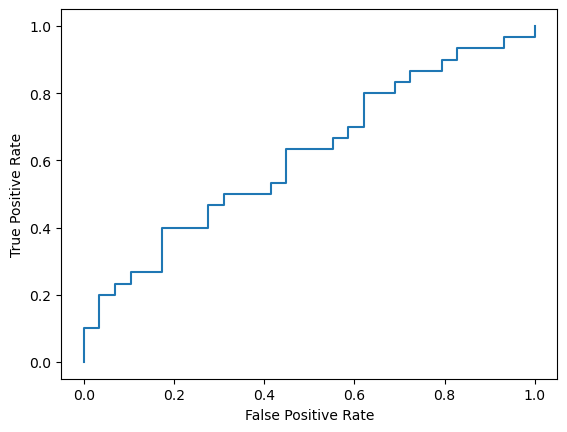

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [29]:
rf = RandomForestClassifier(max_depth=5)

In [30]:
rf.fit(X_train, y_train)
rf.predict(X_test)

array([False, False, False,  True, False, False,  True,  True, False,
        True,  True,  True, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False,  True,  True, False,  True,
        True, False,  True,  True, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True, False, False])

In [31]:
print('\033[1m' + 'Results for the random forest model:' + '\033[0m')
print(f'The accuracy score is: {accuracy_score(y_test, rf.predict(X_test))}' )
print(classification_report(y_test, rf.predict(X_test)))
print(confusion_matrix(y_test, rf.predict(X_test)))

Results for the random forest model:
The accuracy score is: 0.6440677966101694
              precision    recall  f1-score   support

       False       0.64      0.62      0.63        29
        True       0.65      0.67      0.66        30

    accuracy                           0.64        59
   macro avg       0.64      0.64      0.64        59
weighted avg       0.64      0.64      0.64        59

[[18 11]
 [10 20]]


In [32]:
rf.predict_proba(X_test)

array([[0.60245116, 0.39754884],
       [0.6283008 , 0.3716992 ],
       [0.58913083, 0.41086917],
       [0.10380721, 0.89619279],
       [0.79834401, 0.20165599],
       [0.68754876, 0.31245124],
       [0.18017576, 0.81982424],
       [0.29390706, 0.70609294],
       [0.68532938, 0.31467062],
       [0.39950132, 0.60049868],
       [0.25202639, 0.74797361],
       [0.32136825, 0.67863175],
       [0.67070669, 0.32929331],
       [0.51472933, 0.48527067],
       [0.42365116, 0.57634884],
       [0.07283143, 0.92716857],
       [0.66656342, 0.33343658],
       [0.13023649, 0.86976351],
       [0.2390642 , 0.7609358 ],
       [0.61394448, 0.38605552],
       [0.57408148, 0.42591852],
       [0.76629286, 0.23370714],
       [0.62590922, 0.37409078],
       [0.44559635, 0.55440365],
       [0.77190207, 0.22809793],
       [0.69017917, 0.30982083],
       [0.06782794, 0.93217206],
       [0.26467645, 0.73532355],
       [0.58761931, 0.41238069],
       [0.5886491 , 0.4113509 ],
       [0.

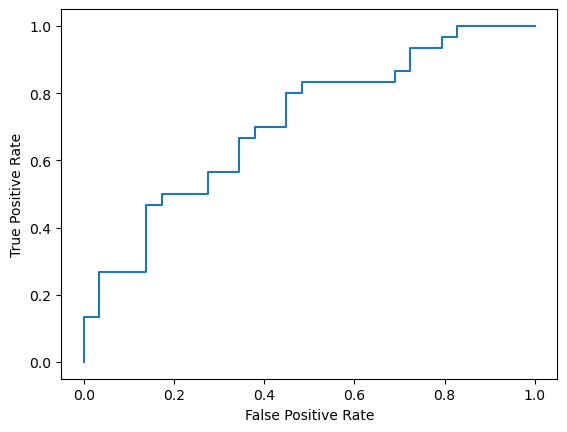

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [34]:
print('\033[1m' + 'Random Forest Model Profit with Default Settings:' + '\033[0m' )
calculate_winnings(rf)

Random Forest Model Profit with Default Settings:
Total Money Bet: $4700.00
Total Revenue: $4588.15
Total Profit: $-111.85


In [35]:
calculate_winnings(rf, 5, .1, .7, .8)

Total Money Bet: $55.00
Total Revenue: $77.01
Total Profit: $22.01


In [39]:
importances = pd.DataFrame({
    'variable': variables,
    'importance': rf.feature_importances_
})

importances.sort_values('importance', ascending = False).reset_index().drop(columns=['index'])
#list(importances.sort_values('importance', ascending = False).head(10)['variable'])

,variable,importance
0,Home_Minus_Away_kickingPoints_season_avg,0.104457
1,Home_Minus_Away_firstDowns_season_avg,0.089310
2,Home_Minus_Away_totalYards_season_avg,0.066428
3,Home_Minus_Away_yardsPerPass_season_avg,0.065224
4,Home_Minus_Away_sacks_season_avg,0.052905
5,Home_Minus_Away_interceptions_season_avg,0.040470
6,Home_Minus_Away_tacklesForLoss_season_avg,0.038845
7,Home_Minus_Away_rushingAttempts_season_avg,0.038476
8,Home_Minus_Away_interceptionYards_season_avg,0.037007
9,Home_Minus_Away_rushingYards_season_avg,0.033275
